In [1]:
import math
import logging
from functools import partial
from collections import OrderedDict
from copy import Error, deepcopy
from re import S
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import logging
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torch.fft
from torch.nn.modules.container import Sequential
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import logging
import math
from functools import partial
from collections import OrderedDict
import torch.optim as optim

ModuleNotFoundError: No module named 'seaborn'

In [2]:
_logger = logging.getLogger(__name__)


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class GlobalFilter(nn.Module):
    def __init__(self, dim, h=14, w=8):
        super().__init__()
        self.complex_weight = nn.Parameter(torch.randn(h, w, dim, 2, dtype=torch.float32) * 0.02)
        self.w = w
        self.h = h

    def forward(self, x, spatial_size=None):
        B, N, C = x.shape
        if spatial_size is None:
            a = b = int(math.sqrt(N))
        else:
            a, b = spatial_size

        x = x.view(B, a, b, C)

        x = x.to(torch.float32)

        x = torch.fft.rfft2(x, dim=(1, 2), norm='ortho')
        weight = torch.view_as_complex(self.complex_weight)
        x = x * weight
        x = torch.fft.irfft2(x, s=(a, b), dim=(1, 2), norm='ortho')

        x = x.reshape(B, N, C)

        return x

class Block(nn.Module):

    def __init__(self, dim, mlp_ratio=4., drop=0., drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, h=14, w=8):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.filter = GlobalFilter(dim, h=h, w=w)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.mlp(self.norm2(self.filter(self.norm1(x)))))
        return x

class BlockLayerScale(nn.Module):

    def __init__(self, dim, mlp_ratio=4., drop=0., drop_path=0., act_layer=nn.GELU, 
                norm_layer=nn.LayerNorm, h=14, w=8, init_values=1e-5):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.filter = GlobalFilter(dim, h=h, w=w)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        self.gamma = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)

    def forward(self, x):
        x = x + self.drop_path(self.gamma * self.mlp(self.norm2(self.filter(self.norm1(x)))))
        return x

class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class DownLayer(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=56, dim_in=64, dim_out=128):
        super().__init__()
        self.img_size = img_size
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.proj = nn.Conv2d(dim_in, dim_out, kernel_size=2, stride=2)
        self.num_patches = img_size * img_size // 4

    def forward(self, x):
        B, N, C = x.size()
        x = x.view(B, self.img_size, self.img_size, C).permute(0, 3, 1, 2)
        x = self.proj(x).permute(0, 2, 3, 1)
        x = x.reshape(B, -1, self.dim_out)
        return x

class GFNet(nn.Module):
    
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 mlp_ratio=4., representation_size=None, uniform_drop=False,
                 drop_rate=0., drop_path_rate=0., norm_layer=None, 
                 dropcls=0):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_chans (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            qk_scale (float): override default qk scale of head_dim ** -0.5 if set
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            hybrid_backbone (nn.Module): CNN backbone to use in-place of PatchEmbed module
            norm_layer: (nn.Module): normalization layer
        """
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)

        self.patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        h = img_size // patch_size
        w = h // 2 + 1

        if uniform_drop:
            print('using uniform droppath with expect rate', drop_path_rate)
            dpr = [drop_path_rate for _ in range(depth)]  # stochastic depth decay rule
        else:
            print('using linear droppath with expect rate', drop_path_rate * 0.5)
            dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        # dpr = [drop_path_rate for _ in range(depth)]  # stochastic depth decay rule
        
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, mlp_ratio=mlp_ratio,
                drop=drop_rate, drop_path=dpr[i], norm_layer=norm_layer, h=h, w=w)
            for i in range(depth)])
        
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size:
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ('fc', nn.Linear(embed_dim, representation_size)),
                ('act', nn.Tanh())
            ]))
        else:
            self.pre_logits = nn.Identity()

        # Classifier head
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        if dropcls > 0:
            print('dropout %.2f before classifier' % dropcls)
            self.final_dropout = nn.Dropout(p=dropcls)
        else:
            self.final_dropout = nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x).mean(1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.final_dropout(x)
        x = self.head(x)
        return x


class GFNetPyramid(nn.Module):
    
    def __init__(self, img_size=224, patch_size=4, num_classes=1000, embed_dim=[64, 128, 256, 512], depth=[2,2,10,4],
                 mlp_ratio=[4, 4, 4, 4],
                 drop_rate=0., drop_path_rate=0., norm_layer=None, init_values=0.001, no_layerscale=False, dropcls=0):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_chans (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            qk_scale (float): override default qk scale of head_dim ** -0.5 if set
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            hybrid_backbone (nn.Module): CNN backbone to use in-place of PatchEmbed module
            norm_layer: (nn.Module): normalization layer
        """
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim[-1]  # num_features for consistency with other models
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)

        self.patch_embed = nn.ModuleList()
        
        patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=3, embed_dim=embed_dim[0])
        num_patches = patch_embed.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim[0]))

        self.patch_embed.append(patch_embed)

        sizes = [56, 28, 14, 7]
        for i in range(4):
            sizes[i] = sizes[i] * img_size // 224

        for i in range(3):
            patch_embed = DownLayer(sizes[i], embed_dim[i], embed_dim[i+1])
            num_patches = patch_embed.num_patches
            self.patch_embed.append(patch_embed)


        self.pos_drop = nn.Dropout(p=drop_rate)
        self.blocks = nn.ModuleList()

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depth))]  # stochastic depth decay rule
        cur = 0
        for i in range(4):
            h = sizes[i]
            w = h // 2 + 1

            if no_layerscale:
                print('using standard block')
                blk = nn.Sequential(*[
                    Block(
                    dim=embed_dim[i], mlp_ratio=mlp_ratio[i],
                    drop=drop_rate, drop_path=dpr[cur + j], norm_layer=norm_layer, h=h, w=w)
                for j in range(depth[i])
                ])
            else:
                print('using layerscale block')
                blk = nn.Sequential(*[
                    BlockLayerScale(
                    dim=embed_dim[i], mlp_ratio=mlp_ratio[i],
                    drop=drop_rate, drop_path=dpr[cur + j], norm_layer=norm_layer, h=h, w=w, init_values=init_values)
                for j in range(depth[i])
                ])
            self.blocks.append(blk)
            cur += depth[i]

        # Classifier head
        self.norm = norm_layer(embed_dim[-1])

        self.head = nn.Linear(self.num_features, num_classes)

        if dropcls > 0:
            print('dropout %.2f before classifier' % dropcls)
            self.final_dropout = nn.Dropout(p=dropcls)
        else:
            self.final_dropout = nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        self.apply(self._init_weights)


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        for i in range(4):
            x = self.patch_embed[i](x)
            if i == 0:
                x = x + self.pos_embed
            x = self.blocks[i](x)

        x = self.norm(x).mean(1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.final_dropout(x)
        x = self.head(x)
        return x

def resize_pos_embed(posemb, posemb_new):
    # Rescale the grid of position embeddings when loading from state_dict. Adapted from
    # https://github.com/google-research/vision_transformer/blob/00883dd691c63a6830751563748663526e811cee/vit_jax/checkpoint.py#L224
    _logger.info('Resized position embedding: %s to %s', posemb.shape, posemb_new.shape)
    ntok_new = posemb_new.shape[1]
    if True:
        posemb_tok, posemb_grid = posemb[:, :1], posemb[0, 1:]
        ntok_new -= 1
    else:
        posemb_tok, posemb_grid = posemb[:, :0], posemb[0]
    gs_old = int(math.sqrt(len(posemb_grid)))
    gs_new = int(math.sqrt(ntok_new))
    _logger.info('Position embedding grid-size from %s to %s', gs_old, gs_new)
    posemb_grid = posemb_grid.reshape(1, gs_old, gs_old, -1).permute(0, 3, 1, 2)
    posemb_grid = F.interpolate(posemb_grid, size=(gs_new, gs_new), mode='bilinear')
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, gs_new * gs_new, -1)
    posemb = torch.cat([posemb_tok, posemb_grid], dim=1)
    return posemb


def checkpoint_filter_fn(state_dict, model):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    if 'model' in state_dict:
        # For deit models
        state_dict = state_dict['model']
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k and len(v.shape) < 4:
            # For old models that I trained prior to conv based patchification
            O, I, H, W = model.patch_embed.proj.weight.shape
            v = v.reshape(O, -1, H, W)
        elif k == 'pos_embed' and v.shape != model.pos_embed.shape:
            # To resize pos embedding when using model at different size from pretrained weights
            v = resize_pos_embed(v, model.pos_embed)
        out_dict[k] = v
    return out_dict

In [3]:
# Initialize logger
logging.basicConfig(level=logging.INFO)
_logger = logging.getLogger(__name__)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_logger.info(f"Using device: {device}")

# Data Preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load ADNI dataset
dataset = datasets.ImageFolder(root='ADNI_AD_NC_2D\AD_NC', transform=transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Initialization
model = GFNet(img_size=224, patch_size=16, in_chans=3, num_classes=2, embed_dim=768, depth=12, mlp_ratio=4, drop_rate=0, drop_path_rate=0.)
model.head = nn.Linear(model.num_features, 2)  # Assuming binary classification
model.to(device)  # Move model to GPU

# Training function
def train_model(model, train_loader, val_loader, num_epochs=25, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        _logger.info(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        _logger.info(f'Validation Accuracy: {correct/total}')

    return model

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total
    _logger.info(f'Test Accuracy: {test_accuracy}')
    return test_accuracy



<>:19: SyntaxWarning: invalid escape sequence '\A'
<>:19: SyntaxWarning: invalid escape sequence '\A'
C:\Users\cocom\AppData\Local\Temp\ipykernel_21004\3368972940.py:19: SyntaxWarning: invalid escape sequence '\A'
  dataset = datasets.ImageFolder(root='ADNI_AD_NC_2D\AD_NC', transform=transform)
INFO:__main__:Using device: cuda


using linear droppath with expect rate 0.0


In [4]:
import math
import logging
from functools import partial
from collections import OrderedDict
from copy import Error, deepcopy
from re import S
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import logging
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import torch.fft
from torch.nn.modules.container import Sequential
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import logging
import math
from functools import partial
from collections import OrderedDict
import torch.optim as optim

In [5]:
_logger = logging.getLogger(__name__)


def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic',
        'mean': IMAGENET_DEFAULT_MEAN, 'std': IMAGENET_DEFAULT_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class GlobalFilter(nn.Module):
    def __init__(self, dim, h=14, w=8):
        super().__init__()
        self.complex_weight = nn.Parameter(torch.randn(h, w, dim, 2, dtype=torch.float32) * 0.02)
        self.w = w
        self.h = h

    def forward(self, x, spatial_size=None):
        B, N, C = x.shape
        if spatial_size is None:
            a = b = int(math.sqrt(N))
        else:
            a, b = spatial_size

        x = x.view(B, a, b, C)

        x = x.to(torch.float32)

        x = torch.fft.rfft2(x, dim=(1, 2), norm='ortho')
        weight = torch.view_as_complex(self.complex_weight)
        x = x * weight
        x = torch.fft.irfft2(x, s=(a, b), dim=(1, 2), norm='ortho')

        x = x.reshape(B, N, C)

        return x

class Block(nn.Module):

    def __init__(self, dim, mlp_ratio=4., drop=0., drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, h=14, w=8):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.filter = GlobalFilter(dim, h=h, w=w)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.drop_path(self.mlp(self.norm2(self.filter(self.norm1(x)))))
        return x

class BlockLayerScale(nn.Module):

    def __init__(self, dim, mlp_ratio=4., drop=0., drop_path=0., act_layer=nn.GELU, 
                norm_layer=nn.LayerNorm, h=14, w=8, init_values=1e-5):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.filter = GlobalFilter(dim, h=h, w=w)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        self.gamma = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)

    def forward(self, x):
        x = x + self.drop_path(self.gamma * self.mlp(self.norm2(self.filter(self.norm1(x)))))
        return x

class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        assert H == self.img_size[0] and W == self.img_size[1], \
            f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x).flatten(2).transpose(1, 2)
        return x


class DownLayer(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=56, dim_in=64, dim_out=128):
        super().__init__()
        self.img_size = img_size
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.proj = nn.Conv2d(dim_in, dim_out, kernel_size=2, stride=2)
        self.num_patches = img_size * img_size // 4

    def forward(self, x):
        B, N, C = x.size()
        x = x.view(B, self.img_size, self.img_size, C).permute(0, 3, 1, 2)
        x = self.proj(x).permute(0, 2, 3, 1)
        x = x.reshape(B, -1, self.dim_out)
        return x

class GFNet(nn.Module):
    
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 mlp_ratio=4., representation_size=None, uniform_drop=False,
                 drop_rate=0., drop_path_rate=0., norm_layer=None, 
                 dropcls=0):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_chans (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            qk_scale (float): override default qk scale of head_dim ** -0.5 if set
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            hybrid_backbone (nn.Module): CNN backbone to use in-place of PatchEmbed module
            norm_layer: (nn.Module): normalization layer
        """
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)

        self.patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        h = img_size // patch_size
        w = h // 2 + 1

        if uniform_drop:
            print('using uniform droppath with expect rate', drop_path_rate)
            dpr = [drop_path_rate for _ in range(depth)]  # stochastic depth decay rule
        else:
            print('using linear droppath with expect rate', drop_path_rate * 0.5)
            dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        # dpr = [drop_path_rate for _ in range(depth)]  # stochastic depth decay rule
        
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, mlp_ratio=mlp_ratio,
                drop=drop_rate, drop_path=dpr[i], norm_layer=norm_layer, h=h, w=w)
            for i in range(depth)])
        
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size:
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ('fc', nn.Linear(embed_dim, representation_size)),
                ('act', nn.Tanh())
            ]))
        else:
            self.pre_logits = nn.Identity()

        # Classifier head
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()

        if dropcls > 0:
            print('dropout %.2f before classifier' % dropcls)
            self.final_dropout = nn.Dropout(p=dropcls)
        else:
            self.final_dropout = nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x).mean(1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.final_dropout(x)
        x = self.head(x)
        return x


class GFNetPyramid(nn.Module):
    
    def __init__(self, img_size=224, patch_size=4, num_classes=1000, embed_dim=[64, 128, 256, 512], depth=[2,2,10,4],
                 mlp_ratio=[4, 4, 4, 4],
                 drop_rate=0., drop_path_rate=0., norm_layer=None, init_values=0.001, no_layerscale=False, dropcls=0):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_chans (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            qk_scale (float): override default qk scale of head_dim ** -0.5 if set
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            hybrid_backbone (nn.Module): CNN backbone to use in-place of PatchEmbed module
            norm_layer: (nn.Module): normalization layer
        """
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim[-1]  # num_features for consistency with other models
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)

        self.patch_embed = nn.ModuleList()
        
        patch_embed = PatchEmbed(
                img_size=img_size, patch_size=patch_size, in_chans=3, embed_dim=embed_dim[0])
        num_patches = patch_embed.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim[0]))

        self.patch_embed.append(patch_embed)

        sizes = [56, 28, 14, 7]
        for i in range(4):
            sizes[i] = sizes[i] * img_size // 224

        for i in range(3):
            patch_embed = DownLayer(sizes[i], embed_dim[i], embed_dim[i+1])
            num_patches = patch_embed.num_patches
            self.patch_embed.append(patch_embed)


        self.pos_drop = nn.Dropout(p=drop_rate)
        self.blocks = nn.ModuleList()

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depth))]  # stochastic depth decay rule
        cur = 0
        for i in range(4):
            h = sizes[i]
            w = h // 2 + 1

            if no_layerscale:
                print('using standard block')
                blk = nn.Sequential(*[
                    Block(
                    dim=embed_dim[i], mlp_ratio=mlp_ratio[i],
                    drop=drop_rate, drop_path=dpr[cur + j], norm_layer=norm_layer, h=h, w=w)
                for j in range(depth[i])
                ])
            else:
                print('using layerscale block')
                blk = nn.Sequential(*[
                    BlockLayerScale(
                    dim=embed_dim[i], mlp_ratio=mlp_ratio[i],
                    drop=drop_rate, drop_path=dpr[cur + j], norm_layer=norm_layer, h=h, w=w, init_values=init_values)
                for j in range(depth[i])
                ])
            self.blocks.append(blk)
            cur += depth[i]

        # Classifier head
        self.norm = norm_layer(embed_dim[-1])

        self.head = nn.Linear(self.num_features, num_classes)

        if dropcls > 0:
            print('dropout %.2f before classifier' % dropcls)
            self.final_dropout = nn.Dropout(p=dropcls)
        else:
            self.final_dropout = nn.Identity()

        trunc_normal_(self.pos_embed, std=.02)
        self.apply(self._init_weights)


    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        for i in range(4):
            x = self.patch_embed[i](x)
            if i == 0:
                x = x + self.pos_embed
            x = self.blocks[i](x)

        x = self.norm(x).mean(1)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.final_dropout(x)
        x = self.head(x)
        return x

def resize_pos_embed(posemb, posemb_new):
    # Rescale the grid of position embeddings when loading from state_dict. Adapted from
    # https://github.com/google-research/vision_transformer/blob/00883dd691c63a6830751563748663526e811cee/vit_jax/checkpoint.py#L224
    _logger.info('Resized position embedding: %s to %s', posemb.shape, posemb_new.shape)
    ntok_new = posemb_new.shape[1]
    if True:
        posemb_tok, posemb_grid = posemb[:, :1], posemb[0, 1:]
        ntok_new -= 1
    else:
        posemb_tok, posemb_grid = posemb[:, :0], posemb[0]
    gs_old = int(math.sqrt(len(posemb_grid)))
    gs_new = int(math.sqrt(ntok_new))
    _logger.info('Position embedding grid-size from %s to %s', gs_old, gs_new)
    posemb_grid = posemb_grid.reshape(1, gs_old, gs_old, -1).permute(0, 3, 1, 2)
    posemb_grid = F.interpolate(posemb_grid, size=(gs_new, gs_new), mode='bilinear')
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, gs_new * gs_new, -1)
    posemb = torch.cat([posemb_tok, posemb_grid], dim=1)
    return posemb


def checkpoint_filter_fn(state_dict, model):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    if 'model' in state_dict:
        # For deit models
        state_dict = state_dict['model']
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k and len(v.shape) < 4:
            # For old models that I trained prior to conv based patchification
            O, I, H, W = model.patch_embed.proj.weight.shape
            v = v.reshape(O, -1, H, W)
        elif k == 'pos_embed' and v.shape != model.pos_embed.shape:
            # To resize pos embedding when using model at different size from pretrained weights
            v = resize_pos_embed(v, model.pos_embed)
        out_dict[k] = v
    return out_dict

In [6]:
# Assuming GFNet and other necessary classes are defined as provided

# Initialize logger
logging.basicConfig(level=logging.INFO)
_logger = logging.getLogger(__name__)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_logger.info(f"Using device: {device}")

# Data Preparation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load ADNI dataset
dataset = datasets.ImageFolder(root='ADNI_AD_NC_2D\AD_NC', transform=transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model Initialization
model = GFNet(img_size=224, patch_size=16, in_chans=3, num_classes=2, embed_dim=768, depth=12, mlp_ratio=4, drop_rate=0, drop_path_rate=0.)
model.head = nn.Linear(model.num_features, 2)  # Assuming binary classification
model.to(device)  # Move model to GPU

# Training function
def train_model(model, train_loader, val_loader, num_epochs=25, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        _logger.info(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        _logger.info(f'Validation Accuracy: {correct/total}')

    return model

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    _logger.info(f'Confusion Matrix:\n{cm}')
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'AD'], yticklabels=['Normal', 'AD'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Compute accuracy
    correct = sum(np.array(all_preds) == np.array(all_labels))
    total = len(all_labels)
    test_accuracy = correct / total
    _logger.info(f'Test Accuracy: {test_accuracy}')
    return test_accuracy



<>:19: SyntaxWarning: invalid escape sequence '\A'
<>:19: SyntaxWarning: invalid escape sequence '\A'
C:\Users\cocom\AppData\Local\Temp\ipykernel_21004\3484060566.py:19: SyntaxWarning: invalid escape sequence '\A'
  dataset = datasets.ImageFolder(root='ADNI_AD_NC_2D\AD_NC', transform=transform)
INFO:__main__:Using device: cuda


using linear droppath with expect rate 0.0


INFO:__main__:Epoch 1/25, Loss: 0.6466486288937267
INFO:__main__:Validation Accuracy: 0.6998689384010485
INFO:__main__:Epoch 2/25, Loss: 0.6122082846607276
INFO:__main__:Validation Accuracy: 0.6998689384010485
INFO:__main__:Epoch 3/25, Loss: 0.6020635841135493
INFO:__main__:Validation Accuracy: 0.6998689384010485
INFO:__main__:Epoch 4/25, Loss: 0.5856585387073591
INFO:__main__:Validation Accuracy: 0.7066404543468764
INFO:__main__:Epoch 5/25, Loss: 0.5352282126149731
INFO:__main__:Validation Accuracy: 0.7667103538663171
INFO:__main__:Epoch 6/25, Loss: 0.39861706988941764
INFO:__main__:Validation Accuracy: 0.8422892092616864
INFO:__main__:Epoch 7/25, Loss: 0.22665207289873127
INFO:__main__:Validation Accuracy: 0.8938401048492791
INFO:__main__:Epoch 8/25, Loss: 0.11452570379276698
INFO:__main__:Validation Accuracy: 0.8778942769768457
INFO:__main__:Epoch 9/25, Loss: 0.07309021707833327
INFO:__main__:Validation Accuracy: 0.9242027086063783
INFO:__main__:Epoch 10/25, Loss: 0.0488516497103327

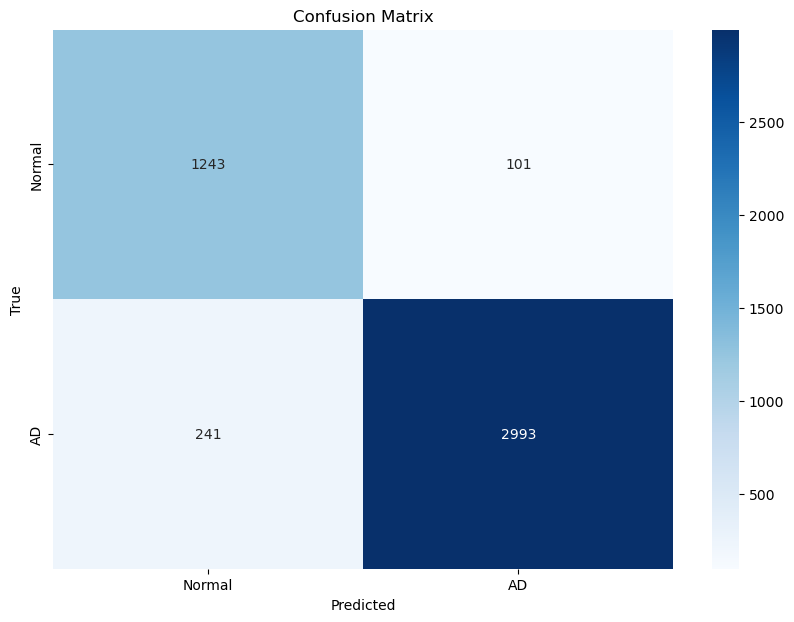

INFO:__main__:Test Accuracy: 0.9252948885976409
C:\Users\cocom\AppData\Local\Temp\ipykernel_21004\1804581572.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_

GFNet(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (filter): GlobalFilter()
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
  (pre_logits): Identity()
  (head): Linear(in_features=768, out_features=2, bias=True)
  (final_dropout): Identity()
)

In [7]:
# Train the model
trained_model = train_model(model, train_loader, val_loader, num_epochs=25, learning_rate=0.001)

# Evaluate the model
test_accuracy = evaluate_model(trained_model, test_loader)

# Save the model
torch.save(trained_model.state_dict(), 'gfnet_adni_model2.pth')

# Load the model for inference
model.load_state_dict(torch.load('gfnet_adni_model.pth'))
model.to(device)  # Ensure the model is on the GPU for inference
model.eval()

In [8]:
# # Evaluate the model
# model.load_state_dict(torch.load('gfnet_adni_model2.pth'))
# test_accuracy = evaluate_model(model, test_loader)
# model.to(device)  # Ensure the model is on the GPU for inference
# model.eval()